# System design Assumptions
- small antenna area 0.3 m x 2 m
- Low Peak Power ~ 200 W i.e. 1/6 Synspective
- High Duty cycle (to compensate for the low peak power) ~ 25%
- Losses + Noise Figure = 10dB (conservative)
- Resolution Area < 2m^2 (like terraSar spotlight)
- Pfa <= 10^-6 i.e. less than 1 fa for NZ EEZ
- 30 m x 7 m vessels to be detected
- LEO = 500 km


In [100]:
# antenna
la = 1.8  # m
wa = .33  # m
# losses + Nf
losses = 10  # dB
# orbit
h = 500e3  # m
# resolution area
ares = 2  # m2
# duty cycle
dutycycle = 0.25
# power
P_peak = 200  # W
pavg = dutycycle * P_peak  # W
# frequency
freq = 10e9
# wavelength
wavel = 299792458.0 / freq
# speed of light
c = 299792458.0

print('P_avg: ', pavg)

P_avg:  50.0


In [101]:
# probability of detection and false alarm
# expected value and variance for MEDIUM ships (150m>L>25m) (from Table 1 in DLR paper) better performance are expected given the higher resolution
# related to the intensity log normal distribution of ships
expected = - 0.002
variance = 4.66

# for small ships with ares , 2m2
# expected = - 0.928
# variance = 3.796

# 30 m x 7 m vessels
A_ship = 30 * 7

#Pfa = 1 * A_ship / 10 ** 7
Pfa = 10e-6

# minimum probability of detection
pd_min = 0.4


In [102]:
# dependencies
import numpy as np
from design_functions import *
import matplotlib.pyplot as plt
import matplotlib
from timing_diagram import time_diagram_plotter
from radartools.farField import UniformAperture
from spherical_earth_geometry_radar import *
from scipy.optimize import fsolve, bisect

matplotlib.use('Qt5Agg')
%matplotlib widget

# I Rationale
-	For a set of physical parameters for the antenna, power and resolution area
-	Assuming that we are using the High resolution azimuthally ambiguous acquisition mode
-	For different looking angles (possible coverage given an orbit)

We need to find what’s the largest possible swath, either limited by range ambiguities or the Probability of Detection:
-	**Probability of detection**: the probability of detection given a probability of false alarm is a function of NESZ i.e. gain pattern tapering and Resolution, which in turn depends on the local incidence angle, the signal bandwidth, and the Processed doppler bandwidth.
-	**Range ambiguities**: the standard design rule to limit Range ambiguities is to keep the swath set by the PRF so that this is equal or larger than the 3 dB elevation antenna beamwidth projected on the ground. Additionally, the PRF is constrained to avoid nadir returns.


In [103]:
theta_mean = np.array([24])

# II Widest Swath System Design Procedure
1.	Set the initial looking angle
2.	Find the signal bandwidth assuming a target resolution area e.g. Ares = 2m^2
3.	Compute the NESZ over range assuming a spherical earth model, an ideal aperture antenna of given size, the bandwidth of point 2, and a set of fixed system parameters (losses, noise figure, power etc.)
4.	Compute the Pd curve over range from the NESZ of point 3
5.	Threshold the Pd curve to a minimum level e.g. Pd = 0.5, and find the swath width.
6.	If the swath width is smaller than the 3-dB elevation beamwidth, consider the 3-dB beamwidth as the swath for the following steps. Else use the swath width of point 5
7.	Using the Swath Width of point 6. Find an initial PRF guess assuming a certain duty cycle e.g. 25 %. (quite large to allow for low peak power)
8.	Align the PRF of 7 to the closest timing diagram valid point to avoid nadir returns
9.	Re-Evaluate the Probability of detection at the swath edges given by the new PRF and duty cycle of point 8 and slightly change the looking angle to center the Probability of detection “beam”
10.	Save the results and try for a different incidence angle


Following the widest swath design procedure with intermediate steps plotting for debug.
All the steps will then be collected in a single fuction to produce a sweep over the looking angle

1. set theta

In [104]:
theta = theta_mean[0]

2. find the bandwidth

In [105]:
B = find_bandwidth(la, theta, ares)
print('Signal Bandwidth: ', B / 1e6, ' MHz')

Signal Bandwidth:  165.84024134119946  MHz


3.	Compute the NESZ over range assuming a spherical earth model, an ideal aperture antenna of given size, the bandwidth of point 2, and a set of fixed system parameters (losses, noise figure, power etc.)
4.	Compute the Pd curve over range from the NESZ of point 3
5.	Threshold the Pd curve to a minimum level e.g. Pd = 0.5, and find the swath width.

In [106]:
# geometry
radGeo = RadarGeometry()
# looking angle
looking_angle = incidence_angle_to_looking_angle(theta * np.pi / 180, h)
radGeo.set_rotation(looking_angle, 0, 0)
# altitude
radGeo.set_initial_position(0, 0, h)
# orbital speed
v_s = radGeo.orbital_speed()
radGeo.set_speed(v_s)
print('looking_angle: ', looking_angle * 180 / np.pi, 'deg')
print('orbital speed:', v_s, 'm/s')
# ideal aperture antenna
uniap = UniformAperture(la, wa, freq)

looking_angle:  22.156551683941565 deg
orbital speed: [7612.68398988] m/s


In [107]:
# elevation limits
el_width = wavel / wa
# incidence angle axis
incidence = np.linspace(theta * np.pi / 180 - el_width, theta * np.pi / 180 + el_width, 51)
# NESZ_core, aximuth resolution using nominal doppler bandwidth
SNR_core, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h)
# nominal doppler bandwidth for reference
Bd = nominal_doppler_bandwidth(la, theta * np.pi / 180, wavel, v_s, h)
print("nominal Doppler Bandwidth:", Bd, 'Hz')

nominal Doppler Bandwidth: [8459.39388183] Hz


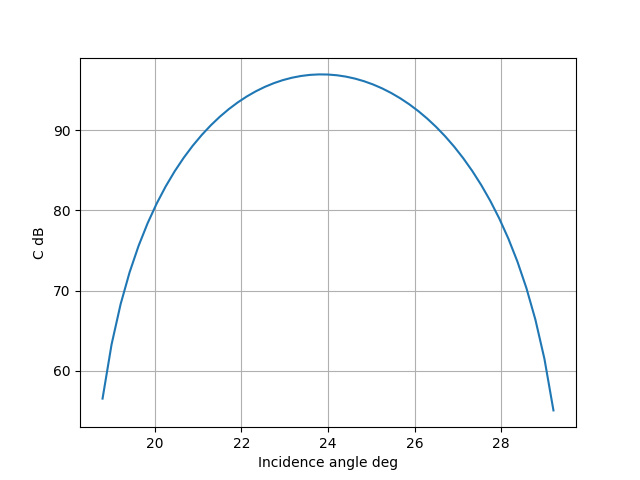

In [108]:
# core SNR plot
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(SNR_core))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('C dB')
ax.grid()

Parametrized NESZ
\begin{equation}
    NESZ = \dfrac{F\ L \ T_a\ B_n}{C\ P_{av}}
\end{equation}

In [109]:
Ta = 300  # k
NESZ = 10 ** (losses / 10) * Ta * B / (SNR_core * pavg)

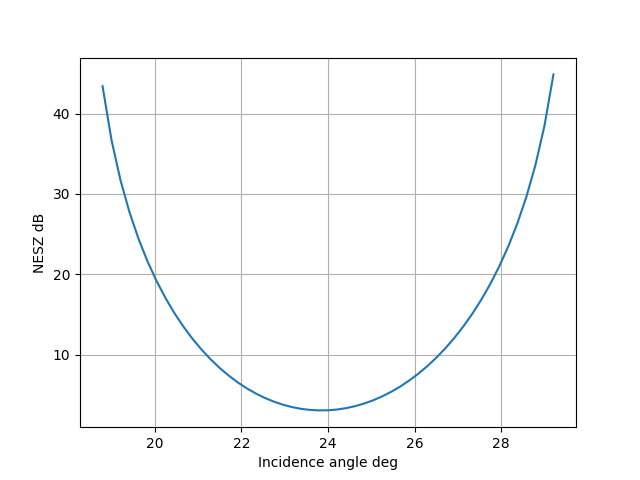

In [110]:
# NESZ plotting
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(NESZ))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('NESZ dB')
ax.grid()

Probability of detection from NESZ, incidence angle and azimuth resolution
\begin{equation}
    \text{T}(P_fa) = -\text{NESZ} ln\left( \dfrac{P_{fa}\ A_{cell}}{A_{ship}} \right)
\end{equation}

\begin{equation}
    P_{d} &\approx 1 - \left[\dfrac{1}{2} + \dfrac{1}{2} \text{erf}\left( \dfrac{\ln(T) - \beta}{\sqrt{2V}} \right)\right]^ {\dfrac{A_{ship}}{A_{cell}}}
\end{equation}

In [111]:
# resolution
A_cell = daz * c / (2 * sin(incidence) * B)
# probability of detection
Pd = pd_from_nesz_res(NESZ, A_cell, Pfa, A_ship, expected, variance)

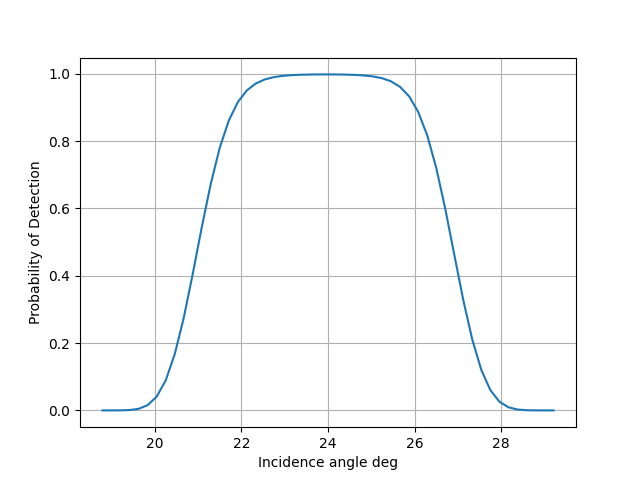

In [112]:
# probability of detection plotting
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, Pd)
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('Probability of Detection')
ax.grid()
plt.show()

find the extremes given a Pd level
(can use a bisecant method for the two sides of the curve)

In [113]:
# 1 define the function to solve
def pd(radGeo, uniap, incidence, wavel, losses, bandwidth, p_avg, Pfa, A_ship, expected, variance):
    h = radGeo.S_0[2]
    v_s = radGeo.abs_v
    # core snr
    c_snr, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h)
    # parametrized NESZ
    Ta = 300  # k
    nesz = 10 ** (losses / 10) * Ta * bandwidth / (c_snr * p_avg)
    # probability of detection
    # resolution
    A_cell = daz * c / (2 * sin(incidence) * B)
    # probability of detection
    Pd = pd_from_nesz_res(nesz, A_cell, Pfa, A_ship, expected, variance)
    return Pd

In [114]:
# 2 solve the function for left and right with respect of broadside
func = lambda inc: pd(radGeo, uniap, inc, wavel, losses, B, pavg, Pfa, A_ship, expected, variance) - pd_min
# left problem
s_inc_right = theta * np.pi / 180 - 0.001
s_inc_left = theta * np.pi / 180 - el_width
# bisecant method
inc_left = bisect(func, s_inc_left, s_inc_right, full_output=True)
print(inc_left)
print("left extreme", inc_left[0] * 180 / np.pi)
# right problem
s_inc_right = theta * np.pi / 180 + el_width
s_inc_left = theta * np.pi / 180 + 0.0001
# bisecant method
inc_right = bisect(func, s_inc_left, s_inc_right, full_output=True)
print(inc_right)
print("right extreme", inc_right[0] * 180 / np.pi)

(0.36423781657186,       converged: True
           flag: 'converged'
 function_calls: 38
     iterations: 36
           root: 0.36423781657186)
left extreme 20.869289628627815
(0.4714144790724771,       converged: True
           flag: 'converged'
 function_calls: 38
     iterations: 36
           root: 0.4714144790724771)
right extreme 27.010060052211205


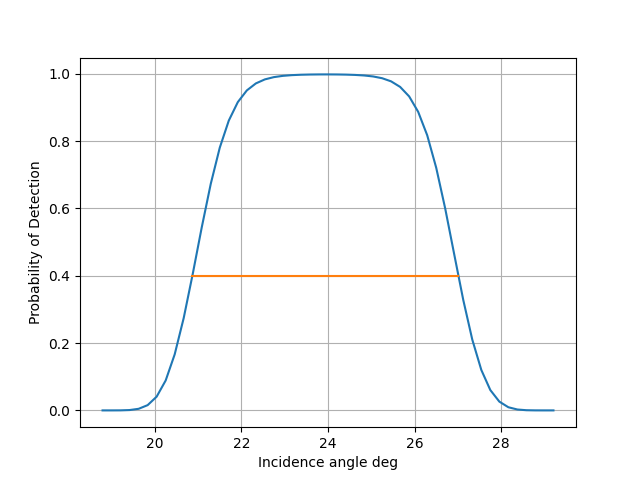

In [115]:
# probability of detection plotting
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, Pd)
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('Probability of Detection')
ax.grid()
inc_pd = np.array([inc_left[0], inc_right[0]])
ax.plot(inc_pd * 180 / np.pi, pd_min * np.ones_like(inc_pd))
plt.show()

In [116]:
swath_s, swath_g = range_from_theta(inc_pd * 180 / np.pi, h)
print('ground swath:', (swath_g[1] - swath_g[0]) / 1000, 'km')

ground swath: 58.33536992095623 km


6.	If the swath width is smaller than the 3-dB elevation beamwidth, consider the 3-dB beamwidth as the swath for the following steps. Else use the swath width of point 5

In [117]:
# 3 dB beamwidth approx
inc_3dB = np.array((theta * np.pi / 180 - el_width / 2, theta * np.pi / 180 + el_width / 2))
# swath choice
inc_left = min(inc_pd[0], inc_3dB[0])
inc_right = max(inc_pd[1], inc_3dB[1])

print('swath angles:')
inc_swat_0 = np.array((inc_left, inc_right))
print(np.array((inc_left, inc_right)) * 180 / np.pi)

if (inc_right - inc_left) > (inc_3dB[1] - inc_3dB[0]):
    print("probability of detection swath, larger than nominal swath")

swath angles:
[20.86928963 27.01006005]
probability of detection swath, larger than nominal swath


7.	Using the Swath Width of point 6. Find an initial PRF guess assuming a certain duty cycle e.g. 25 %. (quite large to allow for low peak power)

In [118]:
# slant range from angles
swath_s, swath_g = range_from_theta(inc_swat_0 * 180 / np.pi, h)
swath_0 = swath_s[1] - swath_s[0]
# PRI considering duty cycle
PRI_0 = 2 * swath_0 / c * 1 / (1 - 2 * dutycycle)
PRI_0
print('initial prf guess', 1 / PRI_0)
print(swath_s)

initial prf guess 3162.4498726254237
[532304.36808394 556003.75226984]


In [119]:
# alligning the PRI to fast time axis
# # step 1 impulse order determination
# average slant range
rs = np.average(swath_s)
order = np.floor(2 * rs / (PRI_0 * c))

# # step 2 adjusted PRI
PRI_1 = 2 * rs / (c * (.5 + order))

# # step 3 adjusted near end and far end range and swath
r2s1 = order * c * PRI_1 / 2
r1s1 = (order + 1) * c * PRI_1 / 2

# # step 4 adjusted ground ranges
r1g1, theta1 = range_slant_to_ground(r1s1)
r2g1, theta2 = range_slant_to_ground(r2s1)
rg1 = r1g1 - r2g1

## updated swath
swath_s = np.array([r2s1, r1s1])
swath_g0 = np.array([r2g1, r1g1])
inc_swat = np.array([theta2, theta1])

In [120]:
print(swath_s)
print(swath_g0)
print(inc_swat * 180 / np.pi)
print('refined PRF guess:', 1 / PRI_1)

[520495.18799529 567812.93235849]
[139262.41054365 259135.91984842]
[16.77012762 29.47583556]
refined PRF guess: 3167.8650581778984


8.	Align the PRF of 7 to the closest timing diagram valid point to avoid nadir returns

In [121]:
theta_1, PRI_2, swath_g = closest_nadir_null(PRI_1, swath_s[0], h, end='near')

print("Corrected PRF = ", 1 / PRI_2)
print('Corrected Ground Range', swath_g )
# new slant range
swath_s = range_ground_to_slant(swath_g,h)
# new incidence range
swath_g, inc_swat = range_slant_to_ground(swath_s, h)
print(inc_swat * 180 / np.pi)

# dutycycle limits
usable_swath_s = swath_s + np.array([dutycycle * PRI_2 * c / 2, - dutycycle * PRI_2 * c / 2])
usable_swath_g, usable_inc = range_slant_to_ground(usable_swath_s, h)
# set the incidence angle in the middle of the usable swath
theta_1 = np.average(usable_inc * 180 / np.pi)

print('Usable ground swath: ', usable_swath_g)
print('Corrected broadside Incidence angle:', theta_1)

Corrected PRF =  3297.7170380000002
Corrected Ground Range [     0.         209920.43194383]
[ 0.         24.51822173]
Usable ground swath:  [103231.18445815 180803.59167401]
Corrected broadside Incidence angle: 16.992387872531438


In [122]:
# adjust radar looking angle
looking_angle = incidence_angle_to_looking_angle(theta_1 / 180 * np.pi, h)
radGeo.set_rotation(looking_angle, 0, 0)

(array([ 1.,  0., -0.]),
 array([ 0.        , -0.96258551,  0.27097812]),
 array([ 0.        , -0.27097812, -0.96258551]))

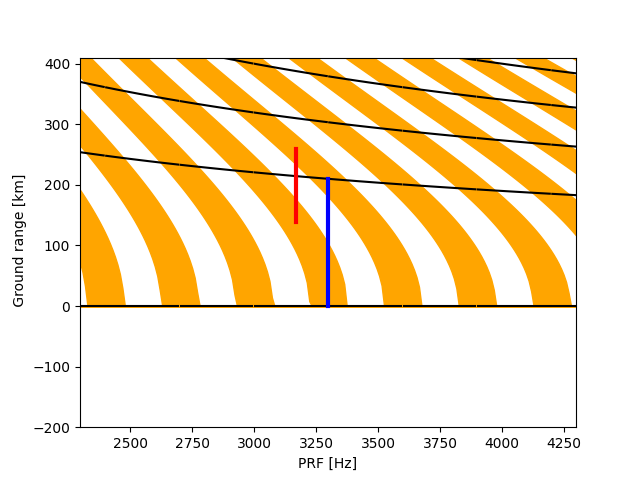

In [123]:
# timing diagram
prf = np.linspace(1 / PRI_2 - 1000, 1 / PRI_2 + 1000, 200)
# plotting
fig, ax = plt.subplots(1)
time_diagram_plotter(ax, prf, dutycycle, h)
ax.set_xlabel('PRF [Hz]')
ax.set_ylabel(' Ground range [km]')
ax.set_ylim(swath_g[0]/1000 - 200, swath_g[1]/1000 + 200 )
ax.set_xlim(1 / PRI_2 - 1000, 1 / PRI_2 + 1000)

# design point
prff = np.abs(np.ones_like(swath_g) / PRI_2)
ax.plot(prff, swath_g / 1000, 'b', linewidth=3)
# PREVIOUS DESIGN POINT
prff = np.abs(np.ones_like(swath_g0) / PRI_1)
ax.plot(prff, swath_g0 / 1000, 'r', linewidth=3)

9.	Re-Evaluate the Probability of detection at the swath edges given by the new PRF and duty cycle of point 8 and slightly change the looking angle to center the Probability of detection “beam”

In [124]:
# new incidence axis
incidence = np.linspace(inc_swat.min(), inc_swat.max(), 51)
# new looking angle probability of detection
Pd = pd(radGeo, uniap, incidence, wavel, losses, B, pavg, Pfa, A_ship, expected, variance)



C:\Users\smen851\PycharmProjects\design-baseline\spherical_earth_geometry_radar.py:488: RuntimeWarning: divide by zero encountered in divide
  SNR_core = lambda_c ** 2 * max_gain ** 2 * c * Bd * vg / (
C:\Users\smen851\AppData\Local\Temp\ipykernel_15440\3573994989.py:12: RuntimeWarning: divide by zero encountered in divide
  A_cell = daz * c / (2 * sin(incidence) * B)
C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:156: RuntimeWarning: invalid value encountered in multiply
  Thresh = - nesz * np.log(pfa * acell / aship)


C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:27: RuntimeWarning: invalid value encountered in arccos
  rg = arccos((re + r * cos(theta)) / (re + h)) * re


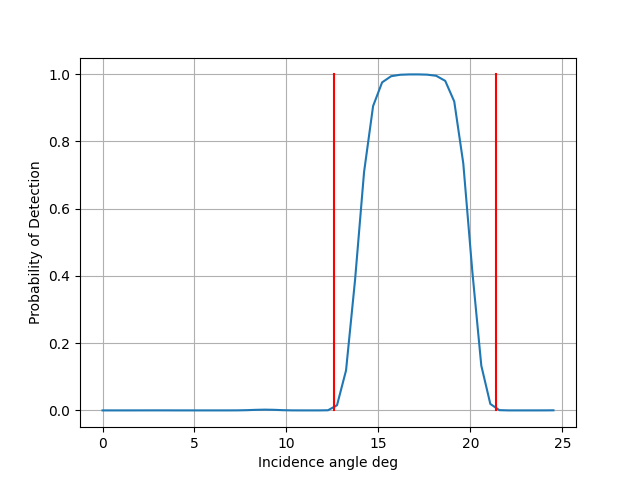

In [125]:
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, Pd)
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('Probability of Detection')
ax.grid()

cpd = np.array([Pd.min(), Pd.max()])
ax.plot(np.ones_like(cpd) * usable_inc[0] * 180 / np.pi, (cpd), 'r')
ax.plot(np.ones_like(cpd) * usable_inc[1] * 180 / np.pi, (cpd), 'r')

plt.show()

Recenter the beam

In [126]:
func = lambda b: pd_error(b, usable_inc[0], usable_inc[1], radGeo, uniap, 10 ** (losses / 10) * Ta * B / pavg, B, Pfa, A_ship, expected,
                          variance)
looking_angle_opt = fsolve(func, looking_angle)
print(looking_angle_opt*180/np.pi)
# recenter the radar
radGeo.set_rotation(looking_angle_opt, 0, 0)
looking_angle = looking_angle_opt

[15.76740892]


In [127]:
# new looking angle probability of detection
Pd = pd(radGeo, uniap, incidence, wavel, losses, B, pavg, Pfa, A_ship, expected, variance)


C:\Users\smen851\AppData\Local\Temp\ipykernel_15440\3573994989.py:12: RuntimeWarning: divide by zero encountered in divide
  A_cell = daz * c / (2 * sin(incidence) * B)


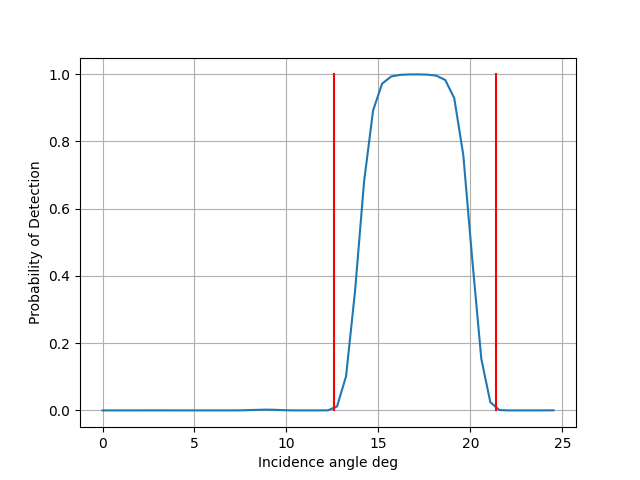

In [128]:
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, Pd)
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('Probability of Detection')
ax.grid()

cpd = np.array([Pd.min(), Pd.max()])
ax.plot(np.ones_like(cpd) * usable_inc[0] * 180 / np.pi, (cpd), 'r')
ax.plot(np.ones_like(cpd) * usable_inc[1] * 180 / np.pi, (cpd), 'r')

plt.show()

# III Analysis

## Range Ambiguity to Signal Ratio: RASR
from Curlander
\begin{equation}
    \text{RASR}_i = \dfrac{\[ \sum_{j=-n_h;\  j \neq 0}^{n_h} \dfrac{\sigma_{ij} \[ \int_{-B_D/2}^{B_D/2}{\left| G\left(\eta_{ij}, f_D\right)\right|^2 \ df_D}{}\]}{R_{ij}^3 \sin{\eta}_{ij}}\]}
                        {\[ \dfrac{\sigma_{i} \[ \int_{-B_D/2}^{B_D/2}{\left| G\left(\eta_{i}, f_D\right)\right|^2 \ df_D}{}\]}{R_{i}^3 \sin{\eta}_{i}}\]}
\end{equation}

with
\begin{equation}
    R_{ij} = c(t_i + j\ \text{PRI}) /2
\end{equation}

\begin{equation}
    \eta_{ij} = \arccos\left( - \dfrac{R_E^2 +R_{ij}^2 - (R_E + h)^2}{2 R_E R_{ij}}\right)
\end{equation}
the problem is symmetric, every range has two gain contributions in the two pattern hemispheres
also $\sigma$ is assumed 1 for simplicity

In [129]:
from ambiguity_functions import RASR

# Nominal doppler bandwidth
looking_angle = radGeo.side_looking_angle
re = 6371e3
r0 = cos(looking_angle) * (re + h) - np.sqrt(
    re ** 2 * cos(looking_angle) ** 2 + 2 * re * cos(looking_angle) ** 2 * h - 2 * re * h + cos(
        looking_angle) ** 2 * h ** 2 - h ** 2)
cos_theta_i = - (-(re + h) ** 2 + re ** 2 + r0 ** 2) / (2 * r0 * re)
# broadside incidence angle
theta_i = np.arccos(cos_theta_i)
#  Doppler Bandwidth
Bd = nominal_doppler_bandwidth(uniap.L, theta_i, wavel, v_s, h)

rasr = RASR(radGeo, uniap, incidence, PRI_2, Bd, wavel, v_s)

C:\Users\smen851\PycharmProjects\design-baseline\ambiguity_functions.py:152: RuntimeWarning: divide by zero encountered in divide
  Denom = Gint / (rax ** 3 * sin(incidence))
100%|██████████| 45/45 [00:01<00:00, 26.94it/s]


C:\Users\smen851\AppData\Local\Temp\ipykernel_15440\1819312482.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(incidence * 180 / np.pi, 10 * np.log10(rasr))


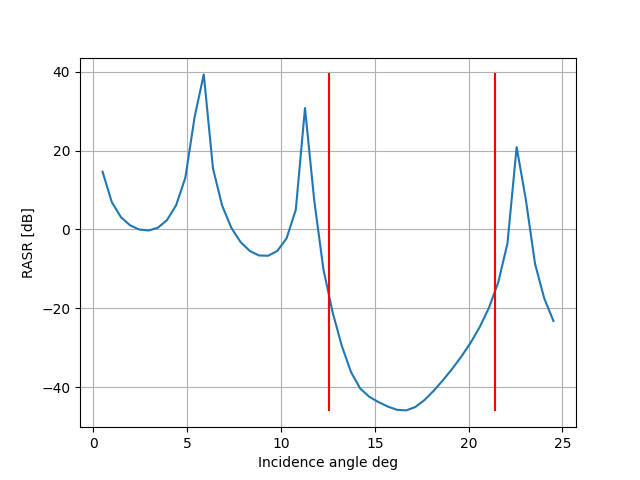

In [141]:
# plotting
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(rasr))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('RASR [dB]')
ax.grid()
rasr = np.where(rasr == 0 , 1 , rasr)
rasrn = np.array([rasr.min(), rasr.max()])
rasrn = np.where(rasrn == 0 , 1 , rasrn)
ax.plot(np.ones_like(cpd) * usable_inc[0] * 180 / np.pi, 10 * np.log10(rasrn), 'r')
ax.plot(np.ones_like(cpd) * usable_inc[1] * 180 / np.pi, 10 * np.log10(rasrn), 'r')

## Azimuth Ambiguity to signal Ratio: AASR
from curlander
\begin{equation}
    \text{AASR} \approx \dfrac{\sum_{m\neq 0}{\int_{B_d}{G^2(f + m \text{PRF})\ df}}}{\int_{B_d}{G^2(f)\ df}}
\end{equation}

In [131]:
from ambiguity_functions import  AASR
aasr = AASR(radGeo, uniap, theta_i * 180 / np.pi, 1/PRI_2, Bd, wavel)
print('AASR= ',10*np.log10(aasr))

[5356.14430017]


100%|██████████| 142/142 [00:03<00:00, 40.61it/s]

AASR=  [4.14243437]


In [132]:
print(Bd*PRI_2)
print(1/PRI_2)
print(theta_i)

[2.56522738]
3297.7170380000002
[0.29742437]


In [132]:
 # todo make this a function to sweep
